<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/045_RL_Deep_Q_Learning_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🕹️ Deep Q-Network (DQN): Gdy Tabela to za mało

Gdy gra jest skomplikowana (np. CartPole, Mario, Doom), nie możemy zapisać wszystkich stanów w tabeli.
Musimy użyć **aproksymatora funkcji** – czyli Sieci Neuronowej.

**Jak to działa?**
1.  **Wejście sieci:** Stan gry (np. 4 liczby w CartPole).
2.  **Wyjście sieci:** Wartości Q dla każdej akcji (np. Lewo: 10 pkt, Prawo: 2 pkt).
3.  Agent wybiera akcję z najwyższym Q.

**Dwa kluczowe triki DQN:**
1.  **Experience Replay (Bufor Pamięci):** Zamiast uczyć się "na bieżąco", agent zapisuje wspomnienia do worka. Potem losuje z niego garść wspomnień i na nich się uczy. To zapobiega zapominaniu starych trików.
2.  **Target Network:** Mamy dwie sieci. Jedna "gra" (Policy Net), druga "ocenia" (Target Net). Co jakiś czas kopiujemy jedną do drugiej. To stabilizuje naukę.

In [1]:
# Instalacja środowiska (jeśli nie masz)
# !uv pip install "gymnasium[classic_control]"

import gymnasium as gym
import math
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# Tworzymy środowisko CartPole-v1
# Cel: Utrzymać tyczkę w pionie jak najdłużej.
env = gym.make("CartPole-v1")

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Obserwacje (Wejście): {env.observation_space.shape[0]} (Pozycja, Prędkość, Kąt, Prędkość Kątowa)")
print(f"Akcje (Wyjście): {env.action_space.n} (Lewo, Prawo)")
print(f"Urządzenie: {device}")

Obserwacje (Wejście): 4 (Pozycja, Prędkość, Kąt, Prędkość Kątowa)
Akcje (Wyjście): 2 (Lewo, Prawo)
Urządzenie: cuda


## Krok 1: Mózg Agenta (Sieć Neuronowa)

Prosta sieć MLP (Multi-Layer Perceptron).
*   Wejście: 4 liczby (Stan).
*   Ukryte: 128 neuronów.
*   Wyjście: 2 liczby (Q-wartość dla Lewo, Q-wartość dla Prawo).

In [2]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Forward: Stan -> Q-Values
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)

print("Model zdefiniowany.")

Model zdefiniowany.


## Krok 2: Replay Memory (Wspomnienia)

Agent nie uczy się od razu po wykonaniu ruchu.
Zapisuje sytuację: `(Stan, Akcja, Nagroda, NowyStan, CzyKoniec)` do listy.
Potem, gdy uzbiera trochę danych, losujemy z listy np. 128 sytuacji i robimy trening (Batch).

To rozbija korelację między kolejnymi klatkami gry (Data Decorrelation).

In [3]:
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity) # deque automatycznie usuwa stare elementy

    def push(self, state, action, next_state, reward, done):
        # Zapisujemy krotkę
        self.memory.append((state, action, next_state, reward, done))

    def sample(self, batch_size):
        # Losujemy próbkę
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

print("Pamięć gotowa.")

Pamięć gotowa.


## Krok 3: Trening (Pętla Gry)

Tutaj dzieje się magia.
1.  **Epsilon-Greedy:** Losujemy ruch (eksploracja) lub pytamy sieć (eksploatacja).
2.  Zapisujemy wynik do pamięci.
3.  **Optimize Model:**
    *   Bierzemy batcha z pamięci.
    *   Liczymy $Q_{expected}$ (z nagrody + Target Network).
    *   Liczymy $Q_{current}$ (co przewidziała nasza sieć).
    *   Liczymy Loss (błąd) i robimy `backward()`.

In [4]:
# Hiperparametry
BATCH_SIZE = 128
GAMMA = 0.99        # Jak ważna jest przyszłość
EPS_START = 0.9     # Początkowa losowość
EPS_END = 0.05      # Końcowa losowość
EPS_DECAY = 1000    # Jak szybko spada losowość
LR = 1e-4           # Learning Rate

# Inicjalizacja
n_actions = env.action_space.n
n_observations = env.observation_space.shape[0]

policy_net = DQN(n_observations, n_actions).to(device) # Sieć "grająca"
target_net = DQN(n_observations, n_actions).to(device) # Sieć "oceniająca" (stabilna)
target_net.load_state_dict(policy_net.state_dict()) # Kopiujemy wagi na start

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    # Wzór na wygaszanie epsilona
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    if sample > eps_threshold:
        with torch.no_grad():
            # Sieć wybiera najlepszą akcję (argmax)
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        # Losowa akcja
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    
    # Pobieramy losowe wspomnienia
    transitions = memory.sample(BATCH_SIZE)
    # Magia Pythona do rozpakowania listy krotek na osobne listy
    batch_state, batch_action, batch_next_state, batch_reward, batch_done = zip(*transitions)

    # Konwersja na tensory
    state_batch = torch.cat(batch_state)
    action_batch = torch.cat(batch_action)
    reward_batch = torch.cat(batch_reward)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch_next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch_next_state if s is not None])

    # 1. Co przewidziała sieć dla tych stanów i akcji?
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 2. Jaka powinna być wartość? (R + gamma * max_Q_z_przyszłości)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        # Tu używamy Target Network dla stabilności!
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
        
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # 3. Obliczamy błąd (Huber Loss - odporny na outliery)
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # 4. Optymalizacja
    optimizer.zero_grad()
    loss.backward()
    # Gradient Clipping (zapobiega wybuchom gradientu)
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

🚀 Start treningu...
Epizod 0 | Wynik: 18 kroków
Epizod 10 | Wynik: 11 kroków
Epizod 20 | Wynik: 19 kroków
Epizod 30 | Wynik: 10 kroków
Epizod 40 | Wynik: 13 kroków
Epizod 50 | Wynik: 14 kroków
Epizod 60 | Wynik: 10 kroków
Epizod 70 | Wynik: 12 kroków
Epizod 80 | Wynik: 9 kroków
Epizod 90 | Wynik: 10 kroków
Epizod 100 | Wynik: 8 kroków
Epizod 110 | Wynik: 12 kroków
Epizod 120 | Wynik: 17 kroków
Epizod 130 | Wynik: 14 kroków
Epizod 140 | Wynik: 13 kroków
Epizod 150 | Wynik: 15 kroków
Epizod 160 | Wynik: 17 kroków
Epizod 170 | Wynik: 98 kroków
Epizod 180 | Wynik: 96 kroków
Epizod 190 | Wynik: 122 kroków
✅ Koniec.


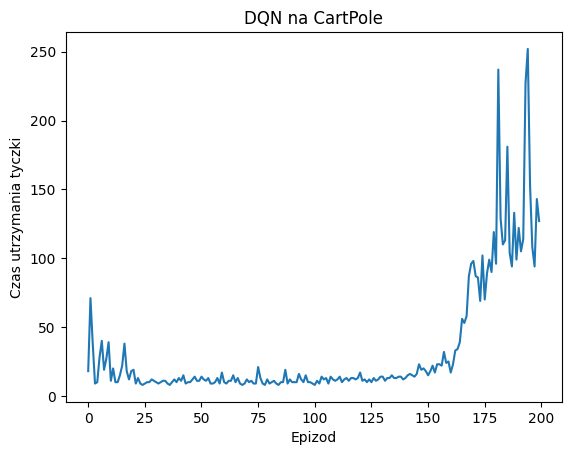

In [5]:
# GŁÓWNA PĘTLA TRENINGOWA
num_episodes = 200 # W CartPole 200-300 epok powinno wystarczyć
episode_durations = []

print("🚀 Start treningu...")

for i_episode in range(num_episodes):
    # Reset środowiska
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    for t in range(1000): # Maksymalnie 1000 klatek na grę
        # 1. Wybierz akcję
        action = select_action(state)
        
        # 2. Wykonaj krok
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # 3. Zapisz do pamięci
        memory.push(state, action, next_state, reward, done)
        state = next_state

        # 4. Trenuj model (jeden krok optymalizacji)
        optimize_model()

        # 5. Soft Update sieci Target (lub Hard Update co X kroków)
        # Tutaj robimy Hard Update co 100 epok w uproszczeniu, ale standardowo robi się to częściej.
        # W tym kodzie uprościmy: Aktualizujemy target_net co 10 epizodów.
        
        if done:
            episode_durations.append(t + 1)
            break

    # Aktualizacja sieci Target (kopiujemy wiedzę z Policy do Target)
    if i_episode % 10 == 0:
        target_net.load_state_dict(policy_net.state_dict())
        print(f"Epizod {i_episode} | Wynik: {t+1} kroków")

print("✅ Koniec.")

# Wykres wyników
plt.plot(episode_durations)
plt.title("DQN na CartPole")
plt.xlabel("Epizod")
plt.ylabel("Czas utrzymania tyczki")
plt.show()

## 🧠 Podsumowanie: Stabilność

Spójrz na wykres.
Na początku (Epsilon bliski 1.0) wynik jest losowy i niski (ok. 10-20 kroków).
W miarę jak Epsilon spada, a sieć się uczy, wynik powinien rosnąć do 200+ (a nawet 500, jeśli pozwolisz).

**Kluczowe wnioski:**
1.  **Replay Buffer** sprawia, że sieć nie "zapomina" starych sytuacji.
2.  **Target Network** sprawia, że cel, do którego dążymy, nie ucieka nam sprzed nosa w trakcie jednej iteracji.

To jest fundament nowoczesnego RL. Na tej zasadzie (plus kilka ulepszeń) działają algorytmy grające w Dota 2 czy StarCrafta.